# Quantum Topological Algorithm

In [161]:
import numpy as np
from numpy import pi
import scipy
import itertools as it
from scipy.sparse import csr_matrix
pi = np.pi
from qiskit.circuit.library import QFT
from qiskit.circuit.library import phase_estimation
from qiskit import QuantumCircuit, Aer, execute,QuantumRegister, ClassicalRegister
from qiskit import transpile
from qiskit.visualization import plot_histogram,plot_bloch_multivector
from qiskit.tools.monitor import job_monitor
#import matplotlib.pyplot as plotter
import seaborn as sns, operator
sns.set_style("dark")


#initialization
import matplotlib.pyplot as plt
#import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

import qiskit
qiskit.__qiskit_version__

{'qiskit-terra': '0.17.4', 'qiskit-aer': '0.8.2', 'qiskit-ignis': '0.6.0', 'qiskit-ibmq-provider': '0.13.1', 'qiskit-aqua': '0.9.1', 'qiskit': '0.26.2', 'qiskit-nature': None, 'qiskit-finance': None, 'qiskit-optimization': None, 'qiskit-machine-learning': None}

Here is space for some .tex commands: 
$$\newcommand{\ket}[1]{\left|{#1}\right\rangle} \newcommand{\bra}[1]{\left\langle{#1}\right|}$$

Here is our first try to write a k-simplex state. The general formula for a k simplex state is:

$\ket{\psi}_k^\epsilon = \frac{1}{\sqrt{|S_k^\epsilon|}} \sum_{s_k \in S_k} \ket{s_k}$

As an example we look at the following simplicial complex:

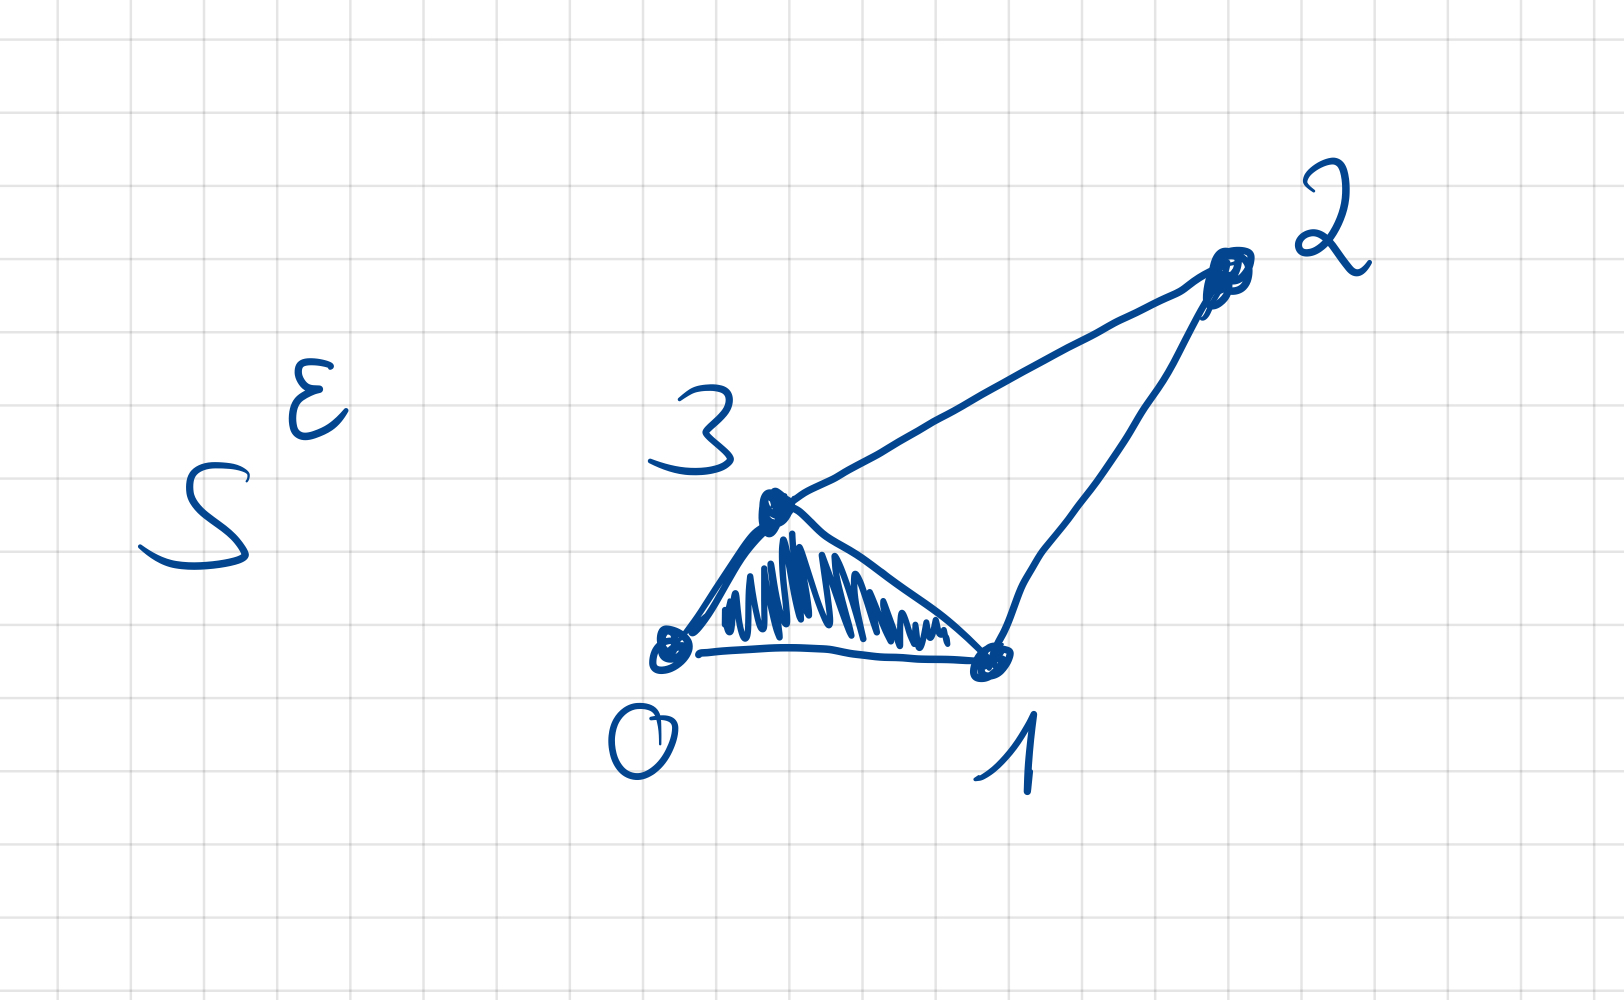

The 0 simplex state looks as: $\ket{\psi}_0 = \frac{1}{4} ( \ket{0001} + \ket{0010} + \ket{0100} + \ket{1000})$

The 1 simplex state looks as: $\ket{\psi}_1 = \frac{1}{\sqrt{5}} ( \ket{0011} + \ket{0110} + \ket{1100} + \ket{1001} + \ket{0101})$

The 2 simplex state looks as: $\ket{\psi}_2 = \ket{1101} $

In [29]:
qc = QuantumCircuit(4)  # Create a quantum circuit with 4 qubits
psi_0 = [0,1/2,1/2,0,1/2,0,0,0,1/2,0,0,0,0,0,0,0]   # Define initial_state as |1>
qc.initialize(psi_0, [0,1,2,3]) # Apply initialisation operation to the 0th qubit
qc.draw()  # Let's view our circuit

print("hello")
transqc = transpile(qc)
qc.draw()


hello


┌──────────────────────────────────────────────────────┐
q_0: ┤0                                                     ├
     │                                                      │
q_1: ┤1                                                     ├
     │  initialize(0,0.5,0.5,0,0.5,0,0,0,0.5,0,0,0,0,0,0,0) │
q_2: ┤2                                                     ├
     │                                                      │
q_3: ┤3                                                     ├
     └──────────────────────────────────────────────────────┘

Define some functions. 'state' is a list of tuples of zeros and ones of length n_vertices, specifying a superposition of simplices. 'vec' is a vector of length 2**n_vertices, specifying the superposition of simplices represented in the multi-quibit basis.


In [31]:
def vec_to_state(vec):
    n_vertices = int(np.log2(len(vec)))
    basis_list = list(it.product(range(2), repeat=n_vertices))
    indices = np.nonzero(vec)[0]
    return {basis_list[i]:vec[i] for i in indices}

def state_to_vec(state):
    ''' state is a list of state '''
    n_vertices = len(state[0])
    basis_list = list(it.product(range(2), repeat=n_vertices))
    basis_dict = {basis_list[i]: i for i in range(2**n_vertices)}
    vec = np.zeros(2**n_vertices)
    for s in state:
        vec[basis_dict[s]] = 1
    return vec

def boundary_operator(x_tuple):
    x_np = np.array(x_tuple)
    indices = np.nonzero(x_np)[0]
    dictionary = {}
    k = len(indices)
    for i in range(k):
        helper = x_np.copy()
        helper[indices[k-1-i]] = 0
        dictionary[tuple(helper)] = (-1)**(i)
    return dictionary

def boundary_operator_dict(n_vertices):
    dictionary = {}
    dictionary[(tuple([0 for i in range(n_vertices)]),tuple([0 for i in range(n_vertices)]))] = 0
    for b in it.product(range(2), repeat=n_vertices):
        helper = boundary_operator(b)
        for key in helper.keys():
            dictionary[(tuple(b),key)] = helper[key]
    return dictionary

def boundary_operator_dict_k(n_vertices, k):
    dictionary = {}
    dictionary[(tuple([0 for i in range(n_vertices)]),tuple([0 for i in range(n_vertices)]))] = 0
    for b in it.product(range(2), repeat=n_vertices):
        if np.sum(b) == k:
            helper = boundary_operator(b)
            for key in helper.keys():
                dictionary[(tuple(b),key)] = helper[key]
    return dictionary

def boundary_operator_crsmat(n_vertices):
    dictionary = boundary_operator_dict(n_vertices)
    basis_list = list(it.product(range(2), repeat=n_vertices))
    basis_dict = {basis_list[i]: i for i in range(2**n_vertices)}
    col = np.array([basis_dict[index[0]] for index in dictionary.keys()])
    row = np.array([basis_dict[index[1]] for index in dictionary.keys()])
    data = np.array(list(dictionary.values()))
    return csr_matrix((data, (row, col)), shape=(2**n_vertices, 2**n_vertices))

def boundary_operator_crsmat_k(n_vertices, k):
    dictionary = boundary_operator_dict_k(n_vertices, k)
    basis_list = list(it.product(range(2), repeat=n_vertices))
    basis_dict = {basis_list[i]: i for i in range(2**n_vertices)}
    col = np.array([basis_dict[index[0]] for index in dictionary.keys()])
    row = np.array([basis_dict[index[1]] for index in dictionary.keys()])
    data = np.array(list(dictionary.values()))
    return csr_matrix((data, (row, col)), shape=(2**n_vertices, 2**n_vertices))

## Get boundary operator as sparse crs matrix

In [32]:
mat = boundary_operator_crsmat(4).toarray()
mat

array([[ 0,  1,  1,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0, -1,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  1,  0,  0, -1,  0,  0,  0, -1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  1,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  1,  1,  0,  0,  0,  0,  0, -1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, -1,  0,  0,  0,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0,  1,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0, -1,  0, -1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  0, -1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,

Check, that $\partial^2 = 0$

In [33]:
mat@mat

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

Example boundary is calculated.

In [34]:
state = [(1,1,0,1,0,0,1)]
n_vertices = len(state[0])
mat = boundary_operator_crsmat(n_vertices).toarray()
vec = state_to_vec(state)
vec_to_state(mat@vec)

{(0, 1, 0, 1, 0, 0, 1): -1.0,
 (1, 0, 0, 1, 0, 0, 1): 1.0,
 (1, 1, 0, 0, 0, 0, 1): -1.0,
 (1, 1, 0, 1, 0, 0, 0): 1.0}

## Combinatorial laplacian of order $k$

In [177]:
k = 2
n_vertices=4

delta_k = boundary_operator_crsmat_k(n_vertices, k).toarray()
delta_kplus1 = boundary_operator_crsmat_k(n_vertices, k+1).toarray()
combinatorial_laplacian = delta_k.conj().T @ delta_k + delta_kplus1 @ delta_kplus1.conj().T

In [188]:
combinatorial_laplacian

array([[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 4, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]])

In [192]:
combinatorial_laplacian
unit = scipy.linalg.expm(1j*combinatorial_laplacian)
unit

array([[ 1.        +0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        +0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ],
       [ 0.        -0.j       ,  1.        +0.j       ,
         0.        -0.j       ,  0.        +0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ,
         0.        -0.j       ,  0.        -0.j       ],
       [ 0.        -0.j       ,  0.        -0.j       ,
         1.        +0.j       ,  0.        +0.

In [288]:
combinatorial_laplacian = np.pi/2*np.diag((1,1,1,1,1,1,1,1))
combinatorial_laplacian 
unit = scipy.linalg.expm(1j*combinatorial_laplacian)

import qiskit.extensions
#gate = qiskit.extensions.HamiltonianGate(combinatorial_laplacian, time=-1)
gate = qiskit.extensions.UnitaryGate(unit)

Now this combinatorial Laplacian needs to be transformed to a quantum Circuit in Qiskit


In [277]:
import qiskit.extensions
#gate = qiskit.extensions.HamiltonianGate(combinatorial_laplacian, time=-1)
gate = qiskit.extensions.UnitaryGate(unit)

#gate = 

## Quantum Fourier Transform

In a first step we initialize the state $\rho_k$. In this starting example we use 3 qubits. num_of_qubits saves the number of qubits in our code. We have num_of_qubits + 1 quantum registers. 

In [286]:
qiskit.__version__
num_of_qubits = 4
unitary = QuantumCircuit(3)
unitary.append(gate, [0,1,2])
unitary.draw()
initialStateCirc = QuantumCircuit(3)
#initialStateCirc.x(1)
#initialStateCirc.x(2)

qpe = qiskit.circuit.library.PhaseEstimation(num_of_qubits, unitary, iqft=None, name='QPE')

qpe = initialStateCirc.combine(qpe)
#qpe.draw()
qpe.measure_all()
qpe.draw()
#qpe.draw()

┌───────────────────────┐┌───────────────────────┐»
   q_0: ─────┤1                      ├┤1                      ├»
             │                       ││                       │»
   q_1: ─────┤2                      ├┤2                      ├»
             │  c_circuit-1304845**1 ││                       │»
   q_2: ─────┤3                      ├┤3 c_circuit-1304845**2 ├»
        ┌───┐│                       ││                       │»
eval_0: ┤ H ├┤0                      ├┤                       ├»
        ├───┤└───────────────────────┘│                       │»
eval_1: ┤ H ├─────────────────────────┤0                      ├»
        ├───┤                         └───────────────────────┘»
eval_2: ┤ H ├──────────────────────────────────────────────────»
        ├───┤                                                  »
eval_3: ┤ H ├──────────────────────────────────────────────────»
        ├───┤                                                  »
eval_4: ┤ H ├──────────────────────────────────────────────────»
        └───┘                                                  »
meas: 8/═══════════════════════════════════════════════════════»
                                                               »
«        ┌───────────────────────┐┌───────────────────────┐»
«   q_0: ┤1                      ├┤1                      ├»
«        │                       ││                       │»
«   q_1: ┤2                      ├┤2                      ├»
«        │                       ││                       │»
«   q_2: ┤3                      ├┤3                      ├»
«        │  c_circuit-1304845**4 ││                       │»
«eval_0: ┤                       ├┤  c_circuit-1304845**8 ├»
«        │                       ││                       │»
«eval_1: ┤                       ├┤                       ├»
«        │                       ││                       │»
«eval_2: ┤0                      ├┤                       ├»
«        └───────────────────────┘│                       │»
«eval_3: ─────────────────────────┤0                      ├»
«                                 └───────────────────────┘»
«eval_4: ──────────────────────────────────────────────────»
«                                                          »
«meas: 8/══════════════════════════════════════════════════»
«                                                          »
«        ┌────────────────────────┐         ░ ┌─┐                     
«   q_0: ┤1                       ├─────────░─┤M├─────────────────────
«        │                        │         ░ └╥┘┌─┐                  
«   q_1: ┤2                       ├─────────░──╫─┤M├──────────────────
«        │                        │         ░  ║ └╥┘┌─┐               
«   q_2: ┤3                       ├─────────░──╫──╫─┤M├───────────────
«        │                        │┌──────┐ ░  ║  ║ └╥┘┌─┐            
«eval_0: ┤                        ├┤0     ├─░──╫──╫──╫─┤M├────────────
«        │  c_circuit-1304845**16 ││      │ ░  ║  ║  ║ └╥┘┌─┐         
«eval_1: ┤                        ├┤1     ├─░──╫──╫──╫──╫─┤M├─────────
«        │                        ││      │ ░  ║  ║  ║  ║ └╥┘┌─┐      
«eval_2: ┤                        ├┤2 qft ├─░──╫──╫──╫──╫──╫─┤M├──────
«        │                        ││      │ ░  ║  ║  ║  ║  ║ └╥┘┌─┐   
«eval_3: ┤                        ├┤3     ├─░──╫──╫──╫──╫──╫──╫─┤M├───
«        │                        ││      │ ░  ║  ║  ║  ║  ║  ║ └╥┘┌─┐
«eval_4: ┤0                       ├┤4     ├─░──╫──╫──╫──╫──╫──╫──╫─┤M├
«        └────────────────────────┘└──────┘ ░  ║  ║  ║  ║  ║  ║  ║ └╥┘
«meas: 8/══════════════════════════════════════╩══╩══╩══╩══╩══╩══╩══╩═
«                                              0  1  2  3  4  5  6  7

{'10111000': 3, '00111000': 3, '10000000': 2, '11010000': 3, '01000000': 2, '00010000': 4, '00100000': 2, '11110000': 21, '01100000': 2, '10110000': 8, '10100000': 1, '00000000': 2, '11000000': 4, '11111000': 4, '00011000': 8, '10010000': 2, '11101000': 8, '11011000': 4, '00110000': 2, '01111000': 3, '10101000': 41, '10011000': 5, '01011000': 3, '01010000': 3, '01101000': 24, '01001000': 813, '00101000': 104, '10001000': 102, '00001000': 33, '11001000': 819, '01110000': 13}


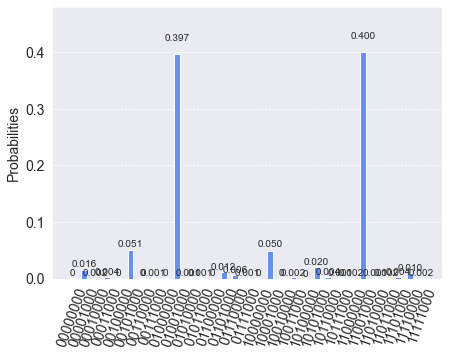

In [287]:
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 2048
t_qpe = transpile(qpe, qasm_sim)
qobj = assemble(t_qpe, shots=shots)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

print(answer)
plot_histogram(answer)

we get: 1100101110 with .955 percent. removing the last three bits, we get 1100101 = 101. This result needs to be divided by 2^n = 128 in our case. So 64 + 32 + 4 + 1 = 101 and 101 / 128 is our $\theta$. 

We expect as an eigenphase exp(3i). Therefore, we get for $\theta$ with exp(2 pi i theta) that $\theta = 3/(2 \pi)$

In [482]:
#initialization
import matplotlib.pyplot as plt
import numpy as np
import math

# importing Qiskit
from qiskit import IBMQ, Aer, transpile, assemble
from qiskit import QuantumCircuit, ClassicalRegister, QuantumRegister

# import basic plot tools
from qiskit.visualization import plot_histogram

In [553]:
test_mode = False

k = 2
n_vertices=3

delta_k = boundary_operator_crsmat_k(n_vertices, k).toarray()
delta_kplus1 = boundary_operator_crsmat_k(n_vertices, k+1).toarray()
combinatorial_laplacian = delta_k.conj().T @ delta_k + delta_kplus1 @ delta_kplus1.conj().T

if(test_mode):
    combinatorial_laplacian = (np.pi/2)*np.diag((1,1,1,1,1,1,1,1))
    combinatorial_laplacian 


unit = scipy.linalg.expm(1j*combinatorial_laplacian)

import qiskit.extensions
#gate = qiskit.extensions.HamiltonianGate(combinatorial_laplacian, time=-1)
gate = qiskit.extensions.UnitaryGate(unit)

In [554]:
combinatorial_laplacian

array([[0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 3, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 3, 0, 0],
       [0, 0, 0, 0, 0, 0, 3, 0],
       [0, 0, 0, 0, 0, 0, 0, 0]])

In [555]:
num_qubits = 5
dim_unitary = 3

In [556]:
qpe = QuantumCircuit(num_qubits + dim_unitary, num_qubits)
#qpe.x(3)
#qpe.draw()

In [557]:
for qubit in range(num_qubits):
    qpe.h(qubit)
qpe.x(5)
qpe.x(6)
qpe.draw()

┌───┐
q_0: ┤ H ├
     ├───┤
q_1: ┤ H ├
     ├───┤
q_2: ┤ H ├
     ├───┤
q_3: ┤ H ├
     ├───┤
q_4: ┤ H ├
     ├───┤
q_5: ┤ X ├
     ├───┤
q_6: ┤ X ├
     └───┘
q_7: ─────
          
c: 5/═════

In [558]:
repetitions = 1
for counting_qubit in range(num_qubits):
    for i in range(repetitions):
        qpe.append(gate.control(1),(counting_qubit,num_qubits,num_qubits+1,num_qubits+2))
    repetitions *= 2
qpe.draw()

┌───┐                                                            »
q_0: ┤ H ├─────■──────────────────────────────────────────────────────»
     ├───┤     │                                                      »
q_1: ┤ H ├─────┼───────────■───────────■──────────────────────────────»
     ├───┤     │           │           │                              »
q_2: ┤ H ├─────┼───────────┼───────────┼───────────■───────────■──────»
     ├───┤     │           │           │           │           │      »
q_3: ┤ H ├─────┼───────────┼───────────┼───────────┼───────────┼──────»
     ├───┤     │           │           │           │           │      »
q_4: ┤ H ├─────┼───────────┼───────────┼───────────┼───────────┼──────»
     ├───┤┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐»
q_5: ┤ X ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
     ├───┤│          ││          ││          ││          ││          │»
q_6: ┤ X ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├»
     └───┘│          ││          ││          ││          ││          │»
q_7: ─────┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├»
          └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ─────■───────────■──────────────────────────────────────────────────────»
«          │           │                                                      »
«q_3: ─────┼───────────┼───────────■───────────■───────────■───────────■──────»
«          │           │           │           │           │           │      »
«q_4: ─────┼───────────┼───────────┼───────────┼───────────┼───────────┼──────»
«     ┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐»
«q_5: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_6: ┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├»
«     │          ││          ││          ││          ││          ││          │»
«q_7: ┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├»
«     └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ─────■───────────■───────────■───────────■──────────────────────────────»
«          │           │           │           │                              »
«q_4: ─────┼───────────┼───────────┼───────────┼───────────■───────────■──────»
«     ┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐»
«q_5: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_6: ┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary 

In [559]:
def qft_dagger(qc, n):
    """n-qubit QFTdagger the first n qubits in circ"""
    # Don't forget the Swaps!
    for qubit in range(n//2):
        qc.swap(qubit, n-qubit-1)
    for j in range(n):
        for m in range(j):
            qc.cp(-math.pi/float(2**(j-m)), m, j)
        qc.h(j)

In [560]:
qpe.barrier()
# Apply inverse QFT
qft_dagger(qpe, num_qubits)
# Measure
qpe.barrier()
for n in range(num_qubits):
    qpe.measure(n,n)

In [561]:
qpe.draw()

┌───┐                                                            »
q_0: ┤ H ├─────■──────────────────────────────────────────────────────»
     ├───┤     │                                                      »
q_1: ┤ H ├─────┼───────────■───────────■──────────────────────────────»
     ├───┤     │           │           │                              »
q_2: ┤ H ├─────┼───────────┼───────────┼───────────■───────────■──────»
     ├───┤     │           │           │           │           │      »
q_3: ┤ H ├─────┼───────────┼───────────┼───────────┼───────────┼──────»
     ├───┤     │           │           │           │           │      »
q_4: ┤ H ├─────┼───────────┼───────────┼───────────┼───────────┼──────»
     ├───┤┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐»
q_5: ┤ X ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
     ├───┤│          ││          ││          ││          ││          │»
q_6: ┤ X ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├»
     └───┘│          ││          ││          ││          ││          │»
q_7: ─────┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├»
          └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
c: 5/═════════════════════════════════════════════════════════════════»
                                                                      »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ─────■───────────■──────────────────────────────────────────────────────»
«          │           │                                                      »
«q_3: ─────┼───────────┼───────────■───────────■───────────■───────────■──────»
«          │           │           │           │           │           │      »
«q_4: ─────┼───────────┼───────────┼───────────┼───────────┼───────────┼──────»
«     ┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐»
«q_5: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_6: ┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├»
«     │          ││          ││          ││          ││          ││          │»
«q_7: ┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├┤2         ├»
«     └──────────┘└──────────┘└──────────┘└──────────┘└──────────┘└──────────┘»
«c: 5/════════════════════════════════════════════════════════════════════════»
«                                                                             »
«                                                                             »
«q_0: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_1: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_2: ────────────────────────────────────────────────────────────────────────»
«                                                                             »
«q_3: ─────■───────────■───────────■───────────■──────────────────────────────»
«          │           │           │           │                              »
«q_4: ─────┼───────────┼───────────┼───────────┼───────────■───────────■──────»
«     ┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐┌────┴─────┐»
«q_5: ┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├┤0         ├»
«     │          ││          ││          ││          ││          ││          │»
«q_6: ┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary ├┤1 unitary 

{'00010': 1, '11110': 1, '01001': 1, '10100': 5, '00111': 7, '00001': 3, '00011': 2, '11101': 2, '00110': 5, '01100': 9, '00100': 3, '10010': 17, '10101': 6, '00101': 4, '11100': 3, '01010': 8, '01101': 23, '10111': 2, '10011': 14, '01110': 68, '11001': 3, '10000': 247, '01111': 1556, '01000': 3, '10001': 44, '01011': 11}


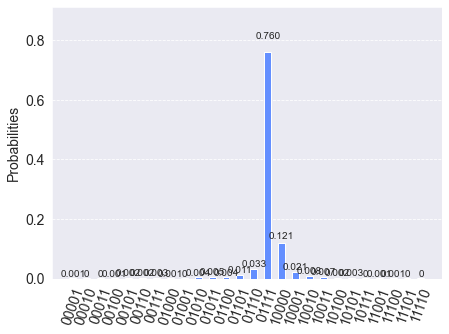

In [563]:
qasm_sim = Aer.get_backend('qasm_simulator')
shots = 2048
t_qpe = transpile(qpe, qasm_sim)
qobj = assemble(t_qpe, shots=shots)
results = qasm_sim.run(qobj).result()
answer = results.get_counts()

print(answer)
plot_histogram(answer)

Sie haben in der Vorlesung gelernt, dass die Quanten Fourier Transformation auf den Zustand $\sum_{i=0}^{N-1} x_i |i\rangle$ wirkt und auf den Zustand $\sum_{i=0}^{N-1} y_i |i\rangle $ abgebildet wird. Dabei ist $ y_k=\frac{1}{\sqrt{N}}\sum_{i=0}^{N-1} x_j \omega_N^{jk} $ mit $ \omega_N^{jk}=e^{2\pi i\frac{jk}{N}} $. Die entsprechende unitäre Matrix kann also durch $ U_{QFT}=\frac{1}{\sqrt{N}}\sum_{x=0}^{N-1}\sum_{y=0}^{N-1}\omega_N^{xy} |y\rangle \langle x| $ beschrieben werden.

### Übung 1
Berechnen Sie für ein einzelnes Qubit $|\psi\rangle=\alpha|0\rangle+\beta|1\rangle$ die QFT, sowie die unitäre Matrix. Welchem Gate entspricht die QFT für ein Qubit?

$ y_0=\frac{1}{\sqrt{2}}\sum_{j=0}^1x_je^{2\pi i \frac{jk}{2}} $
$ =\frac{1}{\sqrt{2}}(\alpha e^{2\pi i \frac{0\cdot 0}{2}}+\beta e^{2\pi i \frac{0\cdot 1}{2}})$
$ =\frac{1}{\sqrt{2}}(\alpha+\beta) $

$ y_1=\frac{1}{\sqrt{2}}\sum_{j=0}^1x_je^{2\pi i \frac{jk}{2}} $
$ =\frac{1}{\sqrt{2}}(\alpha e^{2\pi i \frac{0\cdot 1}{2}}+\beta e^{2\pi i \frac{1\cdot 1}{2}})$
$ =\frac{1}{\sqrt{2}}(\alpha+\beta e^{\pi i}) $
$ =\frac{1}{\sqrt{2}}(\alpha-\beta) $

$ U_{QFT}|\psi\rangle=\frac{1}{\sqrt{2}}(\alpha+\beta)|0\rangle+\frac{1}{\sqrt{2}}(\alpha-\beta)|1\rangle $
$ = \frac{1}{\sqrt{2}}[\alpha|0\rangle+\beta|0\rangle+\alpha|1\rangle-\beta|1\rangle]$
$ = \frac{1}{\sqrt{2}} \begin{pmatrix}1 & 1 \\1 & -1 \end{pmatrix} \begin{pmatrix} \alpha \\ \beta\end{pmatrix}$

Dies entspricht dem Hadamard Gatter.

### Übung 2
In dieser Übung sollen Sie ihre eigene Quanten-Fourier-Transformation erstellen. Zuerst betrachten wir den Fall für 3 Qubits. Programmieren Sie nach der in der Vorlesung (S. 71) gegebenen Anleitung den entsprechenden Quantenschaltkreis. Denken Sie daran, dass in Qiskit die Reihenfolge der Qubits umgekehrt ist (d.h. das Qubit $1$ aus der Vorlesung entspricht in Qiskit dem Qubit $n-1$, und Qubit $n$ aus der Vorlesung dem Qubit $0$ in Qiskit. Mit anderen Worten: der in der Vorlesung gezeigte Schaltkreis muss vertikal gespiegelt werden.) Für das kontrollierte Phasengatter können Sie in Qiskit das Gatter cp verwenden (bzw. cu1, welches genauso funktioniert). Für den Winkel, um den beim Gatter $CR_k$ rotiert werden muss, gilt hierbei: $\theta=\frac{2\pi}{2^k}=\frac{\pi}{2^{k-1}}$.
Zum Schluss muss noch die Reihenfolge der Qubits durch ein SWAP-Gatter vertauscht werden.

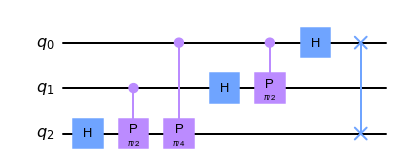

In [5]:
#Schreiben Sie Ihren Code hier und lassen Sie sich am Schluss zur Kontrolle
#Ihren Schaltkreis auf dem Bildschirm zeigen:

qc = QuantumCircuit(3)
qc.h(2)
qc.cp(pi/2, 1, 2) # CROT von Qubit 1 zu Qubit 2
qc.cp(pi/4, 0, 2) # CROT von Qubit 2 zu Qubit 0
qc.h(1)
qc.cp(pi/2, 0, 1)
qc.h(0)
qc.swap(0,2)
qc.draw('mpl')

### Übung 3
Sie haben nun eine QFT für 3 Qubits programmiert. Jetzt soll eine allgemeine QFT-Funktion implementiert werden, die für n Qubits gilt. Dies kann entweder durch eine doppelte "for"-Schleife geschehen (erst "for l in reversed(range(n)):" zum Durchzählen der Qubits in umgekehrter Reihenfolge, dann "for k in reversed(range(l)):", um die kontollierten Rotationen für Qubit $l$ durchzuführen) oder rekursiv (zuerst eine Routine schreiben, die nur für das letzte Qubit das Hadamard-Gatter und alle kontrollierten Rotationen durchführt, und dann dieselbe Funktion mit $n-1$ Qubits nochmal aufrufen). Zum Schluss nicht vergessen, die Reihenfolge der Qubits zu vertauschen!

In [1]:
#Rekursive Variante:
def qft_rotations(circuit, n):    
    if n == 0:
        return circuit
    n -= 1 #da hier n um 1 reduziert wird, kann die Funtkion so lange 
    #aufgerufen werden bis n==0
    circuit.h(n)
    for qubit in reversed(range(n)):
        circuit.cp(pi/2**(n-qubit), qubit, n)    
    qft_rotations(circuit, n) # hier ist n = n-1
def swap_registers(circuit, n):
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit
def qft(circuit, n):
    qft_rotations(circuit, n)
    swap_registers(circuit, n)
    return circuit

In [7]:
#Variante: Doppelte for-Schleife:
def qft2(circuit, n):
    for l in reversed(range(n)):
        circuit.h(l)        
        for k in reversed(range(l)):
            circuit.cp(pi/2**(l-k), k, l)
    for qubit in range(n//2):
        circuit.swap(qubit, n-qubit-1)
    return circuit

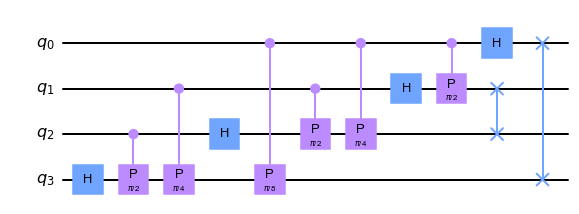

In [10]:
#Geben Sie als Test den Schaltkreis für 4 Qubits aus
qc = QuantumCircuit(4)
qft(qc,4)
#qft2(qc,4) #falls Sie die beiden Varianten vergleichen möchten einfach # löschen und qft auskommentieren
qc.draw('mpl')

Später werden wir auch die invertierte QFT benötigen. Die folgende Funktion fügt einem beliebigen Schaltkreis "circuit" (der auch mehr als n Qubits enthalten darf) eine inverse QFT der ersten n Qubits hinzu:

In [11]:
def inverse_qft(circuit, n):   
    # Zuerst wird ein QFT-Schaltkreis mit n Qubits erstellt:
    qft_circ = qft(QuantumCircuit(n), n) #qft entspricht hier Ihrer Funktion für die QFT
    # dann wird der Schaltkreis invertiert
    invqft_circ = qft_circ.inverse()
    # und zum bereits existierenden Schaltkreis circuit (Qubits 0 bis n-1) hinzugefügt:
    circuit.append(invqft_circ, circuit.qubits[:n])
    return circuit.decompose() # .decompose() wird hier angewendet um einzelne Gates zu sehen

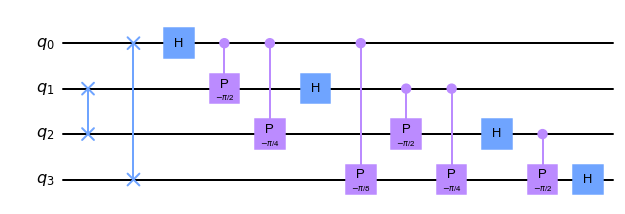

In [12]:
#Schaltkreis der inversen QFT zur Veranschaulichung:
qc = QuantumCircuit(4)
inverse_qft(qc,4)
qc=qc.decompose()
qc.draw('mpl')

## Quantum Phase Estimation

In der Vorlesung haben Sie die Quantum Phase Estimation kennengelernt. Diese soll nun genutzt werden um den Wert von $\pi$ zu erhalten. Sie benötigen dazu ebenso die QFT.
Orientieren Sie sich am Schaltkreis, der in der Vorlesung vorgestellt wurde.

Für einen Operator $U$ und einen Zustand $|\psi\rangle$, welcher ein Eigenvektor von $U$ zum Eigenwert $e^{2\pi i\theta}$ ist (also $U|\psi\rangle=e^{2\pi i\theta}|\psi\rangle$) soll $\theta$ abgeschätzt werden (wobei $0\leq \theta<1$). Der
QPE-Algorithmus mit $t$ Qubits im Register 1 liefert eine Abschätzung für $2^t\theta$, welche für steigendes $t$ immer genauer wird.

In diesem Beispiel wird $U=u_1(1),|\psi\rangle=|1\rangle$ gewählt, wobei $u_1(1)=\begin{pmatrix}
1 & 0\\ 0 & e^{i}\end{pmatrix}$. Der Eigenwert zum Vektor $|1\rangle$ lautet also $e^i=e^{2\pi i \theta}$ mit $\theta=1/(2\pi)$.
Wie oben erwähnt, wird am Ende $2^t \theta$ gemessen, woraus sich $\pi$ also wie folgt ergibt: $\pi=\frac{2^{t-1}}{\rm gemessener\ Wert}$.

Schreiben Sie zunächst eine Funktion für den ersten Teil des QPE-Algorithmus (Vorlesung S. 75): Hadamard-Gatter auf Qubits $0,1,...,t-1$ (Register 1) und Präparation von Qubit $t$ (Register 2) im Zustand $|1\rangle$. Dann Anwendung kontrollierter Rotationen auf Qubit $t$ (wobei erneut auf die Vertauschung der Qubit-Reihenfolge in Register 1 zu achten ist):

In [13]:
#QPE Teil 1, schreiben Sie ihren Code hier:
def qpe_pre(circuit, t):
    circuit.h(range(t))
    circuit.x(t)
    for l in range(t):
        circuit.cp(2**(l),l,t)
        
    return circuit

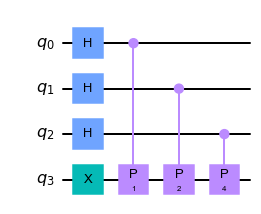

In [14]:
#Überprüfen Sie diesen Teil für 4 Qubits (also t=3)
qc = QuantumCircuit(4) 
qpe_pre(qc,3)
qc.draw('mpl')

In [15]:
#Hier erhalten Sie eine kleine Funktion, sodass sie ihre Schaltkreise simulieren können
def run_job(circuit, backend, shots=1000, optimization_level=0):
    job = execute(circuit, backend=backend, shots=shots, optimization_level=optimization_level)
    job_monitor(job)
    return job.result().get_counts(circuit)

In [16]:
def get_pi_estimate(t):

    # Erstellen Sie den Schaltkreis mit t+1 Qubits und t klassischen Bits
    circ = QuantumCircuit(t + 1, t)
    
    # Rufen Sie Ihre Funktion qpe_pre auf
    qpe_pre(circ, t)
    
    # da Qiskit sonst den Schaltkreis vereinfacht, wird eine Barriere eingesetzt
    circ.barrier()
    
    # Wenden Sie hier Ihre inverse QFT an
    inverse_qft(circ, t)
    
    # da Qiskit sonst den Schaltkreis vereinfacht, wird wieder eine Barriere eingesetzt
    circ.barrier()
    
    # Alle Qubits bis auf das letzte werden gemessen
    circ.measure(range(t), range(t))

    # Simulation des Schaltkreises
    counts = run_job(circ, backend=simulator, shots=10000, optimization_level=0)
    # print(counts) 

    # Counts, die am meisten aufgetreten sind
    max_counts_result = max(counts, key=counts.get)
    #Umwandlung des binären Strings in eine Integer-Zahl
    max_counts_result = int(max_counts_result, 2)
    
    # nach Pi auflösen
    theta = max_counts_result/2**t
    return (1./(2*theta))

In [17]:
#Simulieren
simulator = Aer.get_backend('qasm_simulator')
nqs = list(range(2,12+1))
pi_estimates = []
for nq in nqs:    
    thisnq_pi_estimate = get_pi_estimate(nq)    
    pi_estimates.append(thisnq_pi_estimate)
    
    print(f"{nq} qubits, pi ≈ {thisnq_pi_estimate}")

Job Status: job has successfully run
2 qubits, pi ≈ 2.0
Job Status: job has successfully run
3 qubits, pi ≈ 4.0
Job Status: job has successfully run
4 qubits, pi ≈ 2.6666666666666665
Job Status: job has successfully run
5 qubits, pi ≈ 3.2
Job Status: job has successfully run
6 qubits, pi ≈ 3.2
Job Status: job has successfully run
7 qubits, pi ≈ 3.2
Job Status: job has successfully run
8 qubits, pi ≈ 3.1219512195121952
Job Status: job has successfully run
9 qubits, pi ≈ 3.1604938271604937
Job Status: job has successfully run
10 qubits, pi ≈ 3.1411042944785277
Job Status: job has successfully run
11 qubits, pi ≈ 3.1411042944785277
Job Status: job has successfully run
12 qubits, pi ≈ 3.1411042944785277


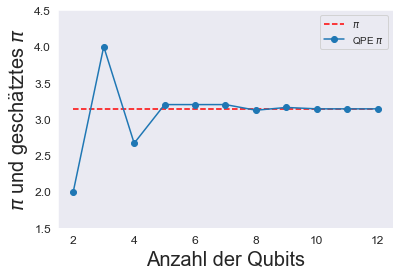

In [19]:
#Graph zur Veranschaulichung der Ergebnisse
plotter.plot(nqs, [pi]*len(nqs), '--r')
plotter.plot(nqs, pi_estimates, '.-', markersize=12)
plotter.xlim([1.5, 12.5])
plotter.ylim([1.5, 4.5])
plotter.legend(['$\pi$', 'QPE $\pi$'])
plotter.xlabel('Anzahl der Qubits', fontdict={'size':20})
plotter.ylabel('$\pi$ und geschätztes $\pi$', fontdict={'size':20})
plotter.tick_params(axis='x', labelsize=12)
plotter.tick_params(axis='y', labelsize=12)
plotter.show()